In [1]:
!python --version

Python 3.11.7


In [2]:
!pip install -U torch torchvision
!pip install wheel==0.34.1

  Attempting uninstall: wheel
    Found existing installation: wheel 0.41.2
    Uninstalling wheel-0.41.2:
      Successfully uninstalled wheel-0.41.2


In [5]:
import torch

In [6]:
import torch
print(torch.__version__ )

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

2.3.0
CUDA is not available.  Training on CPU ...


In [14]:
dataset = '/Users/lerapolovinkina/PycharmProjects/ZernaCoursework/ZernaDataset'
import os
os.listdir("/Users/lerapolovinkina/PycharmProjects/ZernaCoursework/ZernaDataset")

['.DS_Store', 'test', 'train']

In [17]:
!ls /Users/lerapolovinkina/PycharmProjects/ZernaCoursework/ZernaDataset/train


images    train.csv


In [18]:
!ls /Users/lerapolovinkina/PycharmProjects/ZernaCoursework/ZernaDataset/test


images   test.csv


In [19]:
!nvidia-smi
import torch
torch.cuda.is_available()

zsh:1: command not found: nvidia-smi


False

In [23]:
torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [24]:
DEVICE = torch.device("cpu")

In our test there will be 990 pictures for which you will need to predict the class.

In [25]:
import pickle
import numpy as np

from tqdm import tqdm, tqdm_notebook
from pathlib import Path

from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [26]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224
DEVICE = torch.device("cpu")

In [42]:
class ZernaDataset(Dataset):

    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            csv_file_path = '/Users/lerapolovinkina/PycharmProjects/ZernaCoursework/ZernaDataset/train/train.csv'

            self.labels = []

            with open(csv_file_path, newline='') as csvfile:
                csvreader = list(csv.DictReader(csvfile))

                for path in self.files:
                    for row in csvreader:
                        if row['img'] == path.name:
                            self.labels.append(row['class'])

            self.label_encoder.fit(self.labels)

            with open('model.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [43]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [44]:
import os
os.listdir("/Users/lerapolovinkina/PycharmProjects/ZernaCoursework/ZernaDataset/train")

['.DS_Store', 'images', 'train.csv']

In [45]:
import csv

csv_file_path = '/Users/lerapolovinkina/PycharmProjects/ZernaCoursework/ZernaDataset/train/train.csv'

with open(csv_file_path, newline='') as csvfile:
    csvreader = csv.DictReader(csvfile)

In [46]:
TRAIN_DIR = Path('/Users/lerapolovinkina/PycharmProjects/ZernaCoursework/ZernaDataset/train/images')
TEST_DIR = Path('/Users/lerapolovinkina/PycharmProjects/ZernaCoursework/ZernaDataset/test/images')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [47]:
from sklearn.model_selection import train_test_split
import csv

csv_file_path = '/Users/lerapolovinkina/PycharmProjects/ZernaCoursework/ZernaDataset/train/train.csv'

train_val_labels = []

with open(csv_file_path, newline='') as csvfile:
    csvreader = list(csv.DictReader(csvfile))

    for path in train_val_files:
        for row in csvreader:
            if row['img'] == path.name:
                train_val_labels.append(row['class'])

train_files, val_files = train_test_split(train_val_files, test_size=0.25,stratify=train_val_labels)


In [48]:
val_dataset = ZernaDataset(val_files, mode='val')
len(val_dataset)

727

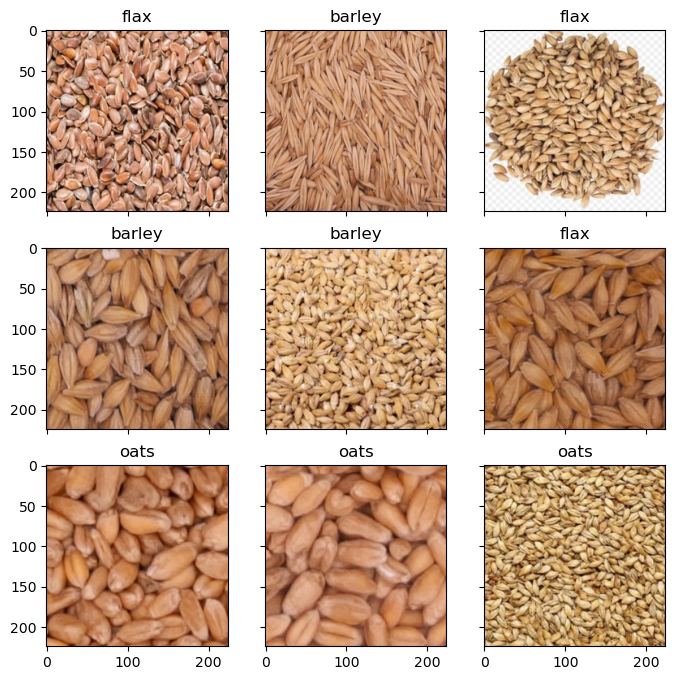

In [49]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,700))
    im_val, label = val_dataset[random_characters]
    img_label = train_val_labels[random_characters]
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [50]:
def fit_epoch(model, train_loader, criterion, optimizer):

    model.train(True)

    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [51]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [52]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=1e-3)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [53]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [54]:
from torchvision.models import resnet50, ResNet50_Weights

weights = ResNet50_Weights.DEFAULT
resnet = resnet50(weights=weights)


for param in resnet.parameters():
    param.requires_grad = False

layers = list(resnet.children())
for layer in layers[-3:]:
    for param in layer.parameters():
        param.requires_grad = True

In [55]:
in_features = 2048
out_features = 45
resnet.fc = nn.Linear(in_features, out_features)
resnet = resnet.to(DEVICE)

In [56]:
if val_dataset is None:
    val_dataset = ZernaDataset(val_files, mode='val')

train_dataset = ZernaDataset(train_files, mode='train')


In [57]:
history = train(train_dataset, val_dataset, model=resnet, epochs=10, batch_size=64)

epoch:   0%|                                             | 0/10 [00:00<?, ?it/s]

loss 0.5164919638576284


epoch:  10%|███▌                                | 1/10 [06:07<55:05, 367.28s/it]


Epoch 001 train_loss: 0.5165     val_loss 0.2253 train_acc 0.8963 val_acc 0.9656
loss 0.09320355760990999


epoch:  20%|███████▏                            | 2/10 [12:30<50:12, 376.59s/it]


Epoch 002 train_loss: 0.0932     val_loss 0.0684 train_acc 0.9729 val_acc 0.9794
loss 0.04813098995003912


epoch:  30%|██████████▊                         | 3/10 [19:09<45:07, 386.73s/it]


Epoch 003 train_loss: 0.0481     val_loss 0.0470 train_acc 0.9890 val_acc 0.9862
loss 0.02561020349528933


epoch:  40%|██████████████▍                     | 4/10 [25:41<38:52, 388.77s/it]


Epoch 004 train_loss: 0.0256     val_loss 0.1015 train_acc 0.9931 val_acc 0.9656
loss 0.08099167243829283


epoch:  50%|██████████████████                  | 5/10 [32:09<32:22, 388.59s/it]


Epoch 005 train_loss: 0.0810     val_loss 0.1429 train_acc 0.9807 val_acc 0.9711
loss 0.05091866512345633


epoch:  60%|█████████████████████▌              | 6/10 [38:38<25:55, 388.89s/it]


Epoch 006 train_loss: 0.0509     val_loss 0.1011 train_acc 0.9849 val_acc 0.9739
loss 0.033262831012334994


epoch:  70%|█████████████████████████▏          | 7/10 [45:17<19:36, 392.09s/it]


Epoch 007 train_loss: 0.0333     val_loss 0.0480 train_acc 0.9913 val_acc 0.9835
loss 0.044574707917469036


epoch:  80%|████████████████████████████▊       | 8/10 [51:51<13:05, 392.77s/it]


Epoch 008 train_loss: 0.0446     val_loss 0.0636 train_acc 0.9904 val_acc 0.9821
loss 0.02733578566784922


epoch:  90%|████████████████████████████████▍   | 9/10 [58:26<06:33, 393.24s/it]


Epoch 009 train_loss: 0.0273     val_loss 0.0468 train_acc 0.9922 val_acc 0.9862
loss 0.0418483122342111


epoch: 100%|█████████████████████████████████| 10/10 [1:05:00<00:00, 390.03s/it]


Epoch 010 train_loss: 0.0418     val_loss 0.1615 train_acc 0.9876 val_acc 0.9794


In [58]:
loss, acc, val_loss, val_acc = zip(*history)
print(loss, acc, val_loss, val_acc)

(0.5164919638576284, 0.09320355760990999, 0.04813098995003912, 0.02561020349528933, 0.08099167243829283, 0.05091866512345633, 0.033262831012334994, 0.044574707917469036, 0.02733578566784922, 0.0418483122342111) (0.8962826984855439, 0.9729233593391464, 0.9889857732905002, 0.9931161083065626, 0.9807251032583754, 0.9848554382744378, 0.9912804038549794, 0.9903625516291877, 0.992198256080771, 0.9876089949518128) (0.22533835883686598, 0.06837761740327046, 0.047004417379218906, 0.10148113248344547, 0.14294634342572793, 0.10106881547006977, 0.047976372599540254, 0.06361470077355921, 0.04684902965366594, 0.16145202707104703) (tensor(0.9656, dtype=torch.float64), tensor(0.9794, dtype=torch.float64), tensor(0.9862, dtype=torch.float64), tensor(0.9656, dtype=torch.float64), tensor(0.9711, dtype=torch.float64), tensor(0.9739, dtype=torch.float64), tensor(0.9835, dtype=torch.float64), tensor(0.9821, dtype=torch.float64), tensor(0.9862, dtype=torch.float64), tensor(0.9794, dtype=torch.float64))


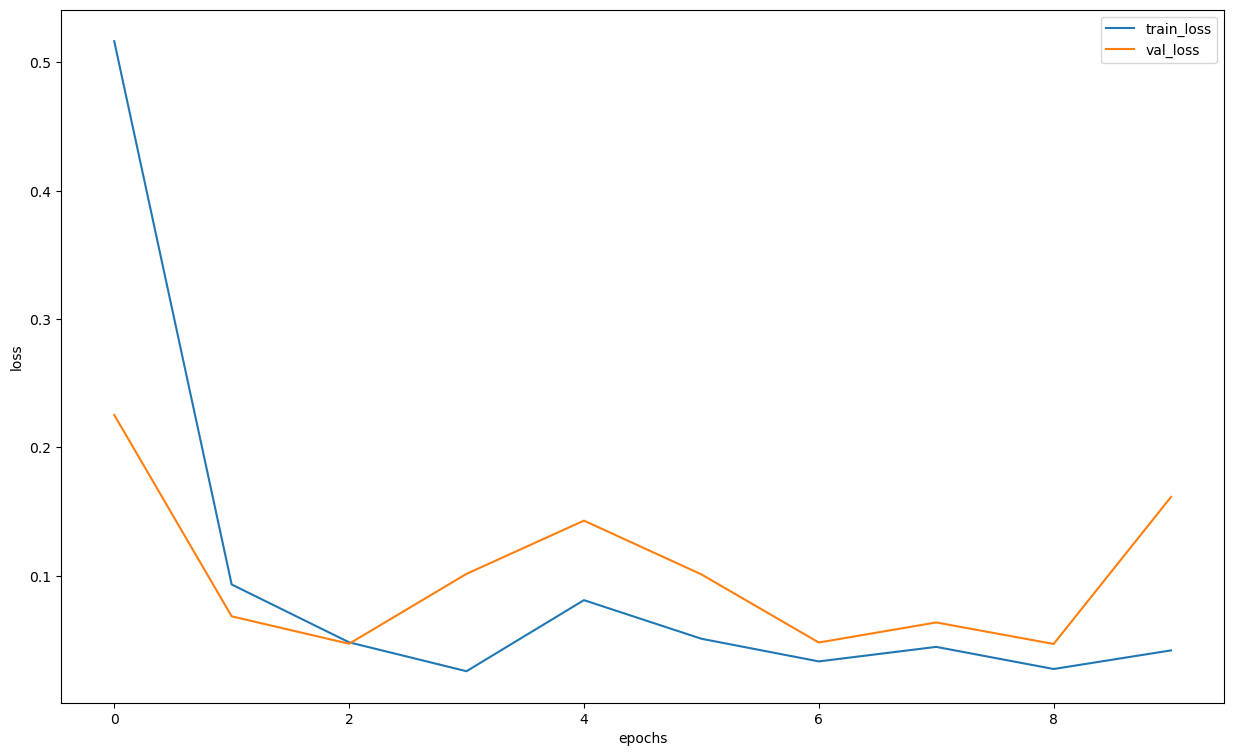

In [59]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [60]:
def predict_one_sample(model, inputs, device=DEVICE):
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [61]:
random_characters = int(np.random.uniform(0,700))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(resnet, ex_img.unsqueeze(0))

In [62]:
idxs = list(map(int, np.random.uniform(0,700, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]
probs_ims = predict(resnet, imgs)


In [64]:
label_encoder = pickle.load(open("model.pkl", 'rb'))

In [65]:
y_pred = np.argmax(probs_ims,-1)
actual_labels = [val_dataset[id][1] for id in idxs]
preds_class = [label_encoder.classes_[i] for i in y_pred]


In [66]:
from sklearn.metrics import f1_score
f1_score(actual_labels, y_pred, average='micro')

1.0

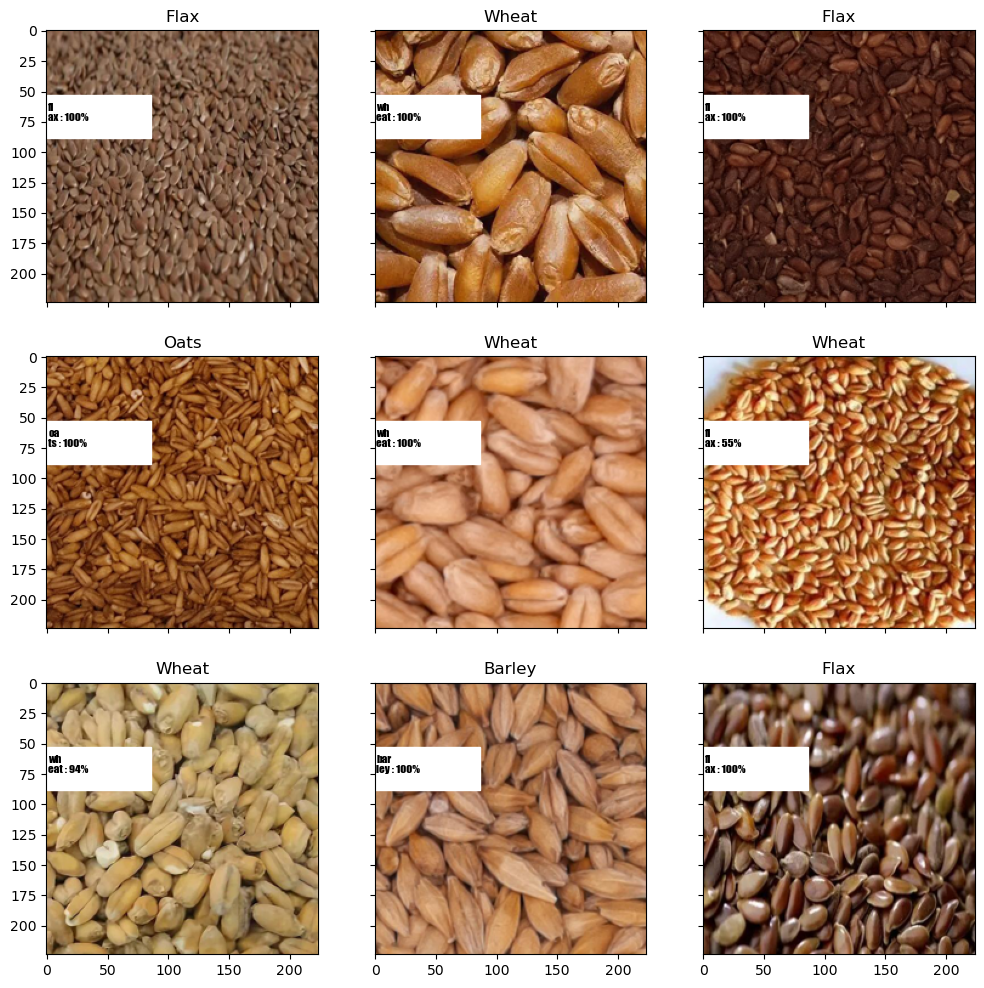

In [67]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,700))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(resnet, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')